# Financial News Sentiment Analysis

This notebook analyzes the correlation between financial news sentiment and stock price movements.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os

# Add src directory to path
sys.path.append(os.path.abspath('..'))

from src.sentiment_analysis import NewsSentimentAnalyzer
from src.stock_data_loader import load_stock_data

# Set plot style
plt.style.use('default')
sns.set_palette('husl')

## Load Data

First, we'll load both the news data and stock data.

In [16]:
# Load news data
news_data = pd.read_csv('../data/raw_analyst_ratings.csv')
print(f"News data shape: {news_data.shape}")
news_data.head()

News data shape: (1407328, 6)


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [17]:
# Load stock data for all symbols
symbols = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
stock_data = load_stock_data(symbols, data_dir='../data')

for symbol in symbols:
    if symbol in stock_data:
        print(f"{symbol} data range: {stock_data[symbol].index.min()} to {stock_data[symbol].index.max()}")
    else:
        print(f"No data found for {symbol}")

AAPL data range: 0 to 10997
AMZN data range: 0 to 6845
GOOG data range: 0 to 5019
META data range: 0 to 2925
MSFT data range: 0 to 9671
NVDA data range: 0 to 6420
TSLA data range: 0 to 3544


## Initialize Sentiment Analyzer and Calculate Sentiment Scores

We'll create an instance of NewsSentimentAnalyzer and calculate sentiment scores for all headlines.

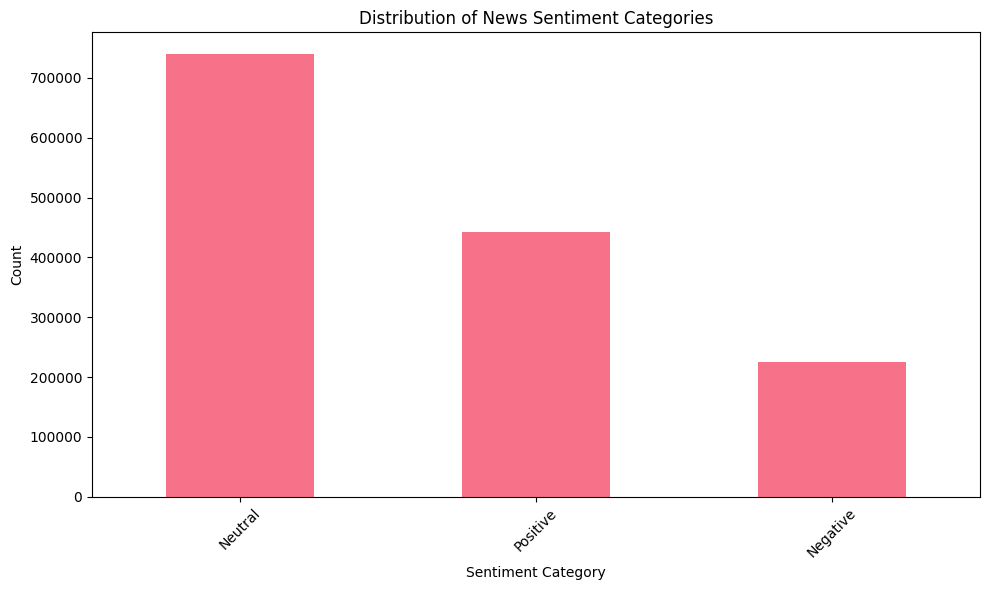

In [24]:
# Import required libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize analyzer with fixed datetime parsing
class NewsSentimentAnalyzerFixed:
    """A class for analyzing news sentiment and its correlation with stock movements."""
    
    def __init__(self, news_df, stock_data):
        """
        Initialize the NewsSentimentAnalyzer with news and stock data.
        """
        self.news_df = news_df.copy()
        self.stock_data = {symbol: df.copy() for symbol, df in stock_data.items()}
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        
        # Convert date columns to datetime with correct format
        self.news_df['date'] = pd.to_datetime(self.news_df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        for symbol in self.stock_data:
            self.stock_data[symbol]['Date'] = pd.to_datetime(self.stock_data[symbol]['Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    
    def calculate_headline_sentiment(self):
        """Calculate sentiment scores for all headlines."""
        # Calculate sentiment scores
        self.news_df['sentiment_scores'] = self.news_df['headline'].apply(
            lambda x: self.sentiment_analyzer.polarity_scores(str(x))
        )
        
        # Extract compound score (overall sentiment)
        self.news_df['sentiment_score'] = self.news_df['sentiment_scores'].apply(
            lambda x: x['compound']
        )
        
        # Add sentiment categories
        self.news_df['sentiment_category'] = pd.cut(
            self.news_df['sentiment_score'],
            bins=[-1, -0.05, 0.05, 1],
            labels=['Negative', 'Neutral', 'Positive']
        )
    
    def calculate_sentiment(self):
        """Calculate sentiment scores for all headlines and return the dataframe with sentiment."""
        self.calculate_headline_sentiment()
        return self.news_df
    
    def get_daily_sentiment(self, symbol):
        """Calculate daily sentiment scores for a specific stock."""
        # Filter news for the specific stock
        stock_news = self.news_df[self.news_df['stock'] == symbol].copy()
        
        # Group by date and calculate daily metrics
        daily_sentiment = stock_news.groupby('date').agg({
            'sentiment_score': ['mean', 'count'],
            'sentiment_category': lambda x: x.mode().iloc[0] if not x.empty else 'Neutral'
        }).reset_index()
        
        # Flatten column names
        daily_sentiment.columns = ['date', 'avg_sentiment', 'article_count', 'sentiment_category']
        
        return daily_sentiment
    
    def analyze_correlation(self, symbol, max_lag=5):
        """Analyze correlation between sentiment and stock returns with time lag analysis."""
        # Get daily sentiment
        daily_sentiment = self.get_daily_sentiment(symbol)
        
        # Get stock returns
        stock_df = self.stock_data[symbol].copy()
        stock_df['return'] = stock_df['Close'].pct_change()
        
        # Merge sentiment and stock data
        merged_data = pd.merge(
            daily_sentiment,
            stock_df[['Date', 'return']],
            left_on='date',
            right_on='Date',
            how='inner'
        )
        
        # Calculate overall correlation
        overall_correlation = merged_data['avg_sentiment'].corr(merged_data['return'])
        
        # Time lag analysis
        lag_correlations = {}
        best_lag = 0
        best_correlation = 0
        
        for lag in range(-max_lag, max_lag + 1):
            if lag != 0:
                merged_data[f'return_lag_{lag}'] = merged_data['return'].shift(-lag)
                corr = merged_data['avg_sentiment'].corr(merged_data[f'return_lag_{lag}'])
                lag_correlations[lag] = corr
                
                if abs(corr) > abs(best_correlation):
                    best_correlation = corr
                    best_lag = lag
        
        return {
            'overall_correlation': overall_correlation,
            'best_lag': best_lag,
            'best_lag_correlation': best_correlation,
            'lag_correlations': lag_correlations
        }
    
    def plot_sentiment_analysis(self, symbol, start_date=None, end_date=None):
        """Plot sentiment analysis results for a stock."""
        # Get daily sentiment
        daily_sentiment = self.get_daily_sentiment(symbol)
        
        # Get stock data
        stock_df = self.stock_data[symbol].copy()
        
        # Filter by date range if provided
        if start_date:
            start_date = pd.to_datetime(start_date, format='%Y-%m-%d', errors='coerce')
            daily_sentiment = daily_sentiment[daily_sentiment['date'] >= start_date]
            stock_df = stock_df[stock_df['Date'] >= start_date]
        if end_date:
            end_date = pd.to_datetime(end_date, format='%Y-%m-%d', errors='coerce')
            daily_sentiment = daily_sentiment[daily_sentiment['date'] <= end_date]
            stock_df = stock_df[stock_df['Date'] <= end_date]
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])
        
        # Plot stock price
        ax1.plot(stock_df['Date'], stock_df['Close'], label='Stock Price', color='blue')
        ax1.set_ylabel('Price', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Plot sentiment on secondary y-axis
        ax1_twin = ax1.twinx()
        ax1_twin.bar(daily_sentiment['date'], daily_sentiment['avg_sentiment'],
                    alpha=0.3, label='Sentiment Score', color='green')
        ax1_twin.set_ylabel('Sentiment Score', color='green')
        ax1_twin.tick_params(axis='y', labelcolor='green')
        
        # Plot article count
        ax2.bar(daily_sentiment['date'], daily_sentiment['article_count'],
                label='Article Count', color='gray', alpha=0.7)
        ax2.set_ylabel('Number of Articles')
        ax2.set_xlabel('Date')
        
        # Add legends and title
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        ax2.legend(loc='upper left')
        
        plt.suptitle(f'Sentiment Analysis for {symbol}', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def plot_time_lag_correlation(self, symbol, max_lag=5):
        """Plot time lag correlation analysis for a stock."""
        correlation_data = self.analyze_correlation(symbol, max_lag)
        lag_correlations = correlation_data['lag_correlations']
        
        lags = list(lag_correlations.keys())
        correlations = list(lag_correlations.values())
        
        plt.figure(figsize=(12, 6))
        plt.bar(lags, correlations, alpha=0.7, color='skyblue')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Same Day')
        
        # Highlight best lag
        best_lag = correlation_data['best_lag']
        best_corr = correlation_data['best_lag_correlation']
        plt.bar(best_lag, best_corr, color='red', alpha=0.8, label=f'Best Lag: {best_lag} days')
        
        plt.xlabel('Time Lag (days)')
        plt.ylabel('Correlation Coefficient')
        plt.title(f'Time Lag Correlation Analysis for {symbol}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"Best lag correlation: {best_corr:.3f} at {best_lag} days")
        print(f"Overall correlation: {correlation_data['overall_correlation']:.3f}")
    
    def get_sentiment_summary(self, symbol):
        """Generate a summary of sentiment analysis for a stock."""
        # Filter news for the specific stock
        stock_news = self.news_df[self.news_df['stock'] == symbol].copy()
        
        # Calculate overall sentiment
        overall_sentiment = stock_news['sentiment_score'].mean()
        
        # Get total articles count
        total_articles = len(stock_news)
        
        # Get sentiment distribution - convert to proper dictionary
        sentiment_dist = stock_news['sentiment_category'].value_counts(normalize=True)
        sentiment_dict = {}
        for category in ['Positive', 'Neutral', 'Negative']:
            sentiment_dict[category.lower()] = sentiment_dist.get(category, 0)
        
        # Get top positive and negative headlines
        top_positive = stock_news.nlargest(5, 'sentiment_score')[['headline', 'sentiment_score', 'date']]
        top_negative = stock_news.nsmallest(5, 'sentiment_score')[['headline', 'sentiment_score', 'date']]
        
        return {
            'overall_sentiment': overall_sentiment,
            'total_articles': total_articles,
            'sentiment_distribution': sentiment_dict,
            'top_positive_news': top_positive.to_dict('records'),
            'top_negative_news': top_negative.to_dict('records')
        }

# Initialize analyzer with the fixed class
analyzer = NewsSentimentAnalyzerFixed(news_data, stock_data)

# Calculate sentiment scores
news_with_sentiment = analyzer.calculate_sentiment()

# Display sentiment distribution
plt.figure(figsize=(10, 6))
news_with_sentiment['sentiment_category'].value_counts().plot(kind='bar')
plt.title('Distribution of News Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analyze Each Stock

For each stock, we'll:
1. Generate a sentiment summary
2. Analyze correlation between sentiment and returns
3. Plot sentiment analysis results


Analyzing AAPL

Sentiment Summary:
Overall Sentiment: 0.06
Total Articles: 441

Sentiment Distribution:
{'positive': np.float64(0.34467120181405897), 'neutral': np.float64(0.4376417233560091), 'negative': np.float64(0.21768707482993196)}

Correlation Analysis:
Overall Correlation: nan
Best Lag: 0 days
Best Lag Correlation: 0.000


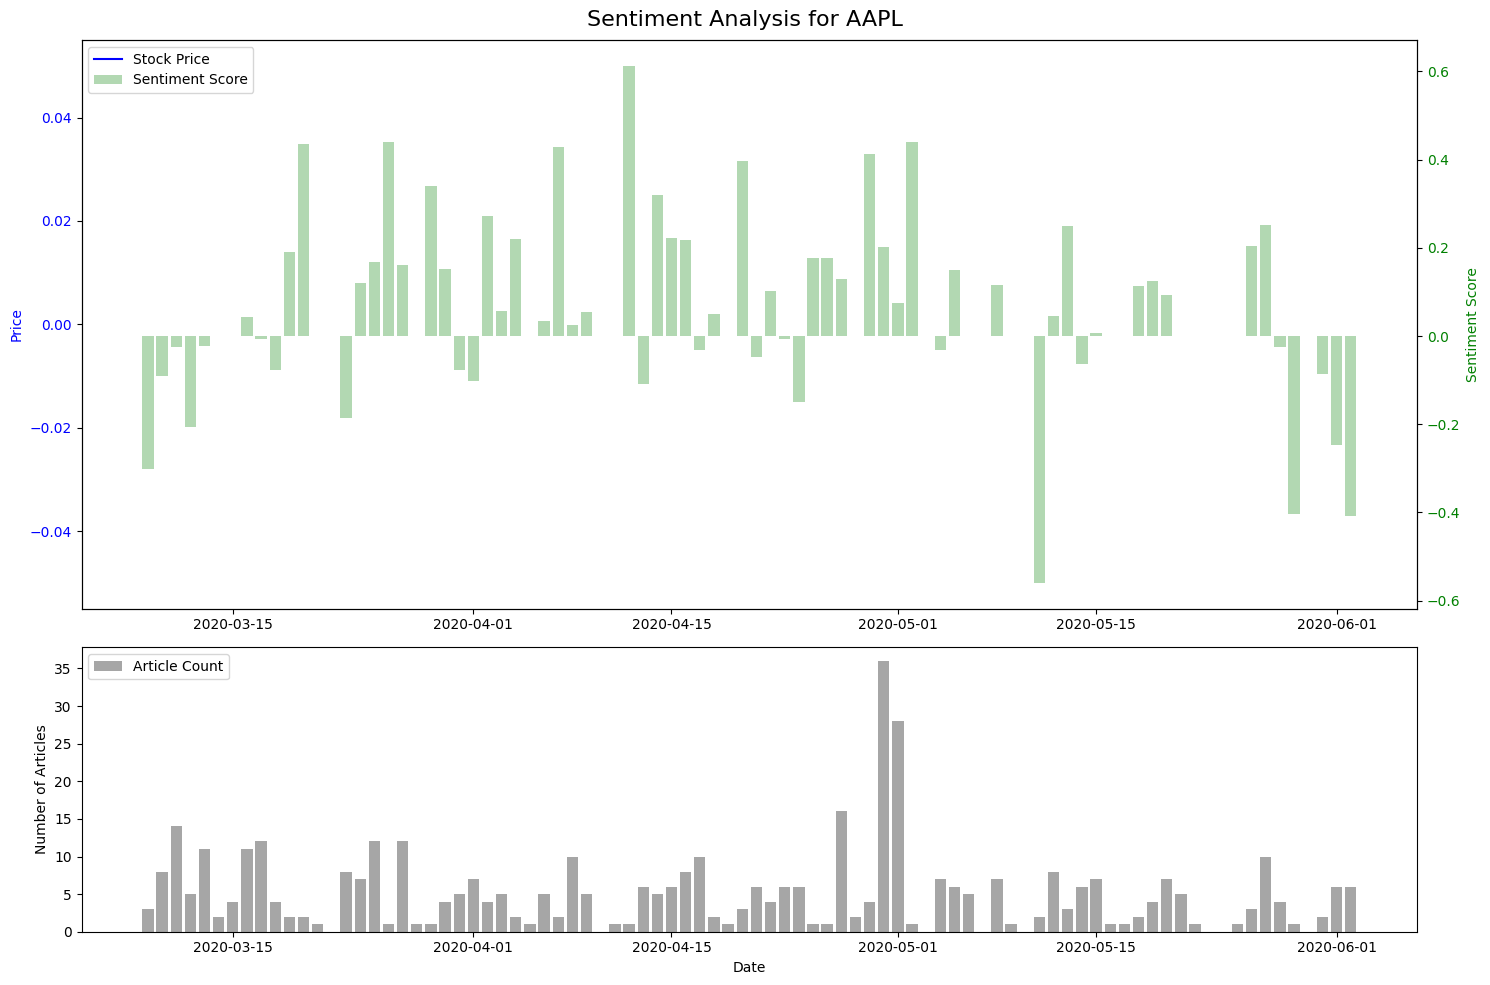

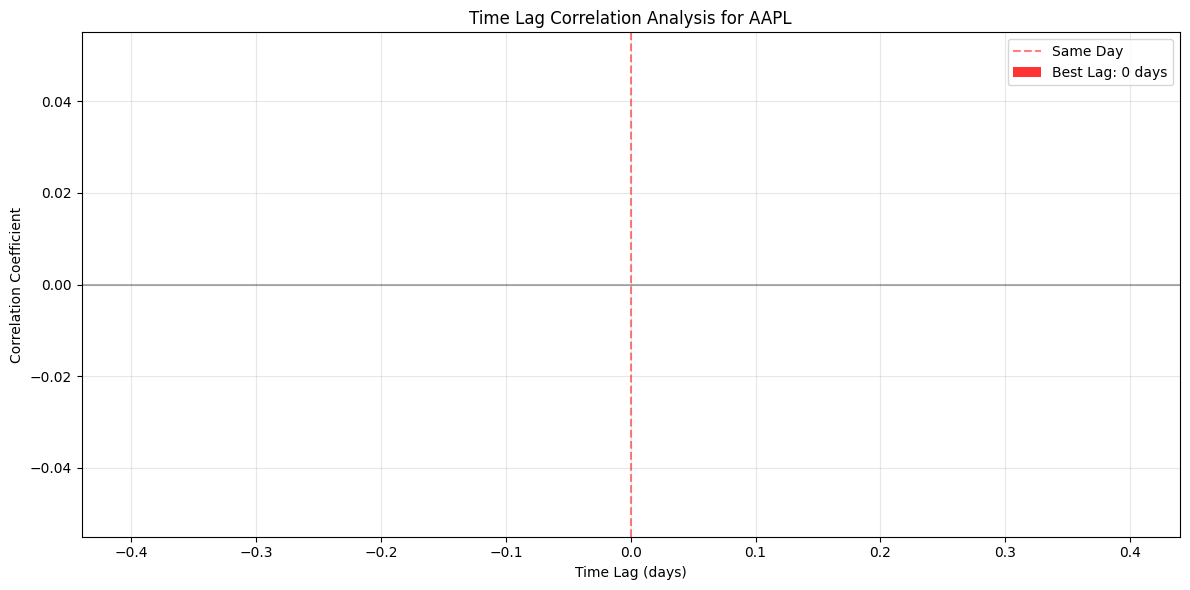

Best lag correlation: 0.000 at 0 days
Overall correlation: nan

Analyzing AMZN

Sentiment Summary:
Overall Sentiment: 0.11
Total Articles: 278

Sentiment Distribution:
{'positive': np.float64(0.49280575539568344), 'neutral': np.float64(0.3381294964028777), 'negative': np.float64(0.16906474820143885)}

Correlation Analysis:
Overall Correlation: nan
Best Lag: 0 days
Best Lag Correlation: 0.000


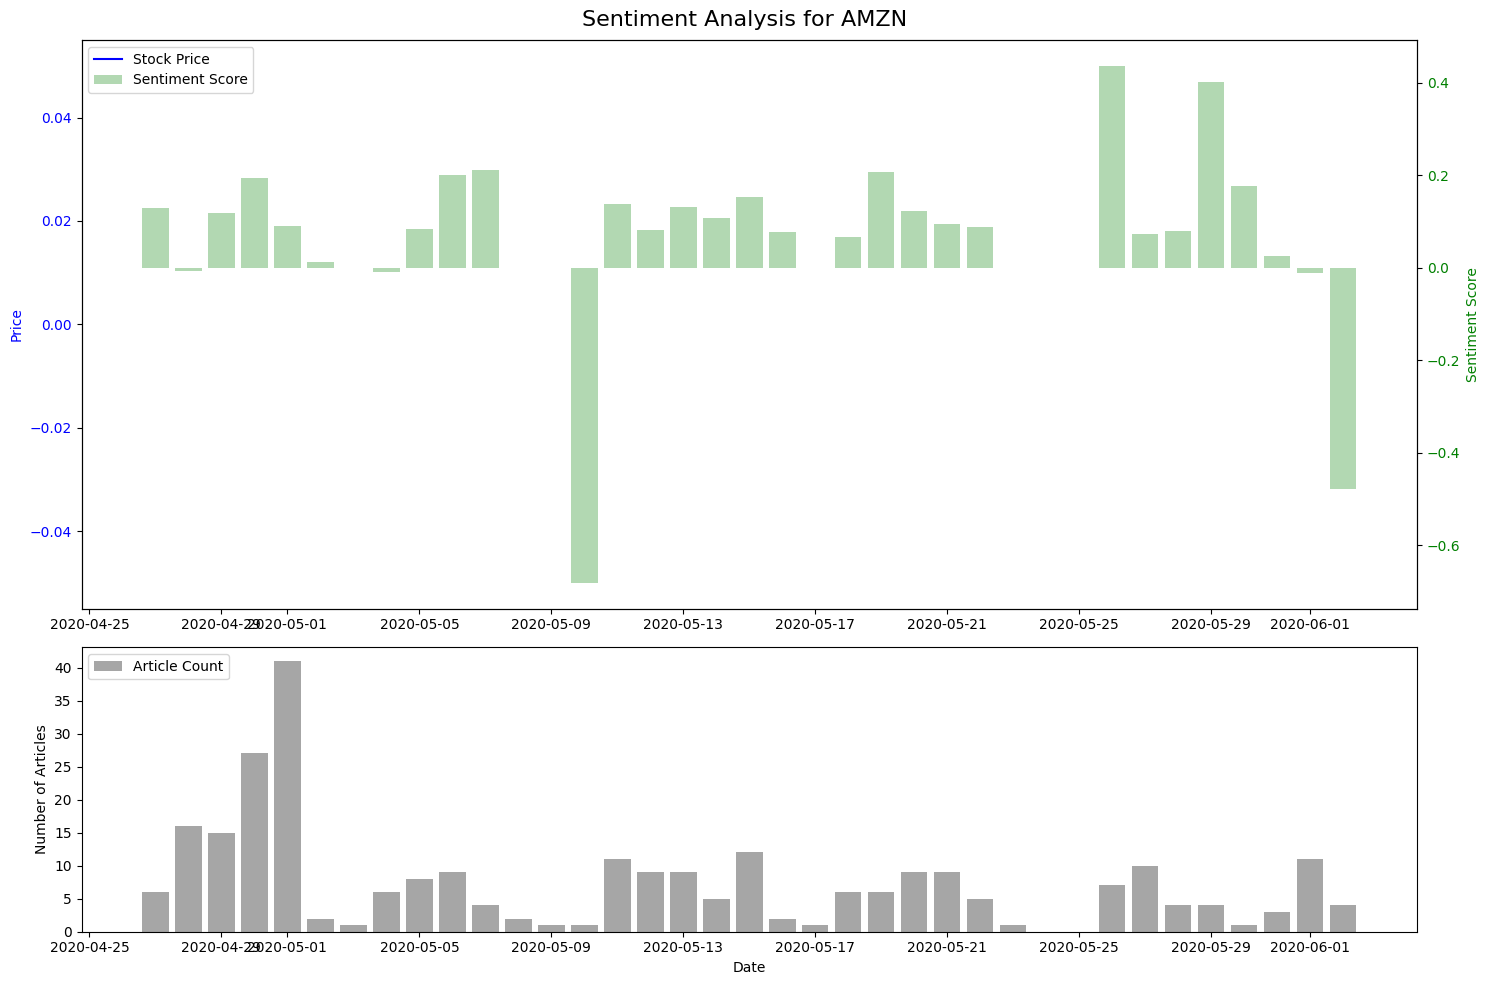

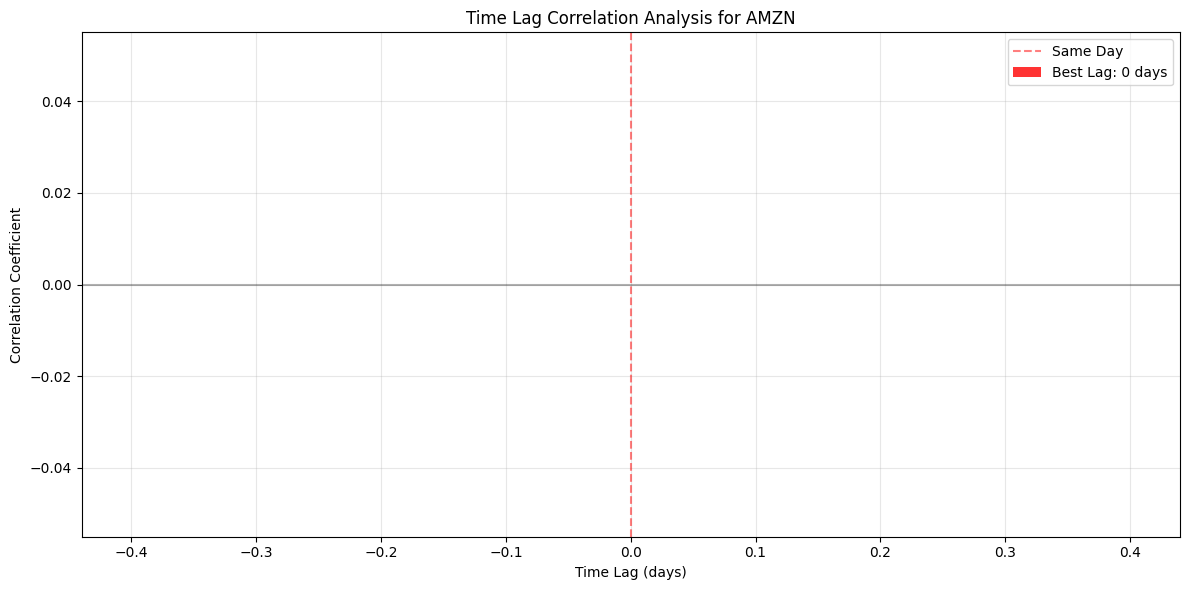

Best lag correlation: 0.000 at 0 days
Overall correlation: nan

Analyzing GOOG

Sentiment Summary:
Overall Sentiment: 0.08
Total Articles: 1199

Sentiment Distribution:
{'positive': np.float64(0.35279399499582986), 'neutral': np.float64(0.4670558798999166), 'negative': np.float64(0.18015012510425354)}

Correlation Analysis:
Overall Correlation: nan
Best Lag: 0 days
Best Lag Correlation: 0.000


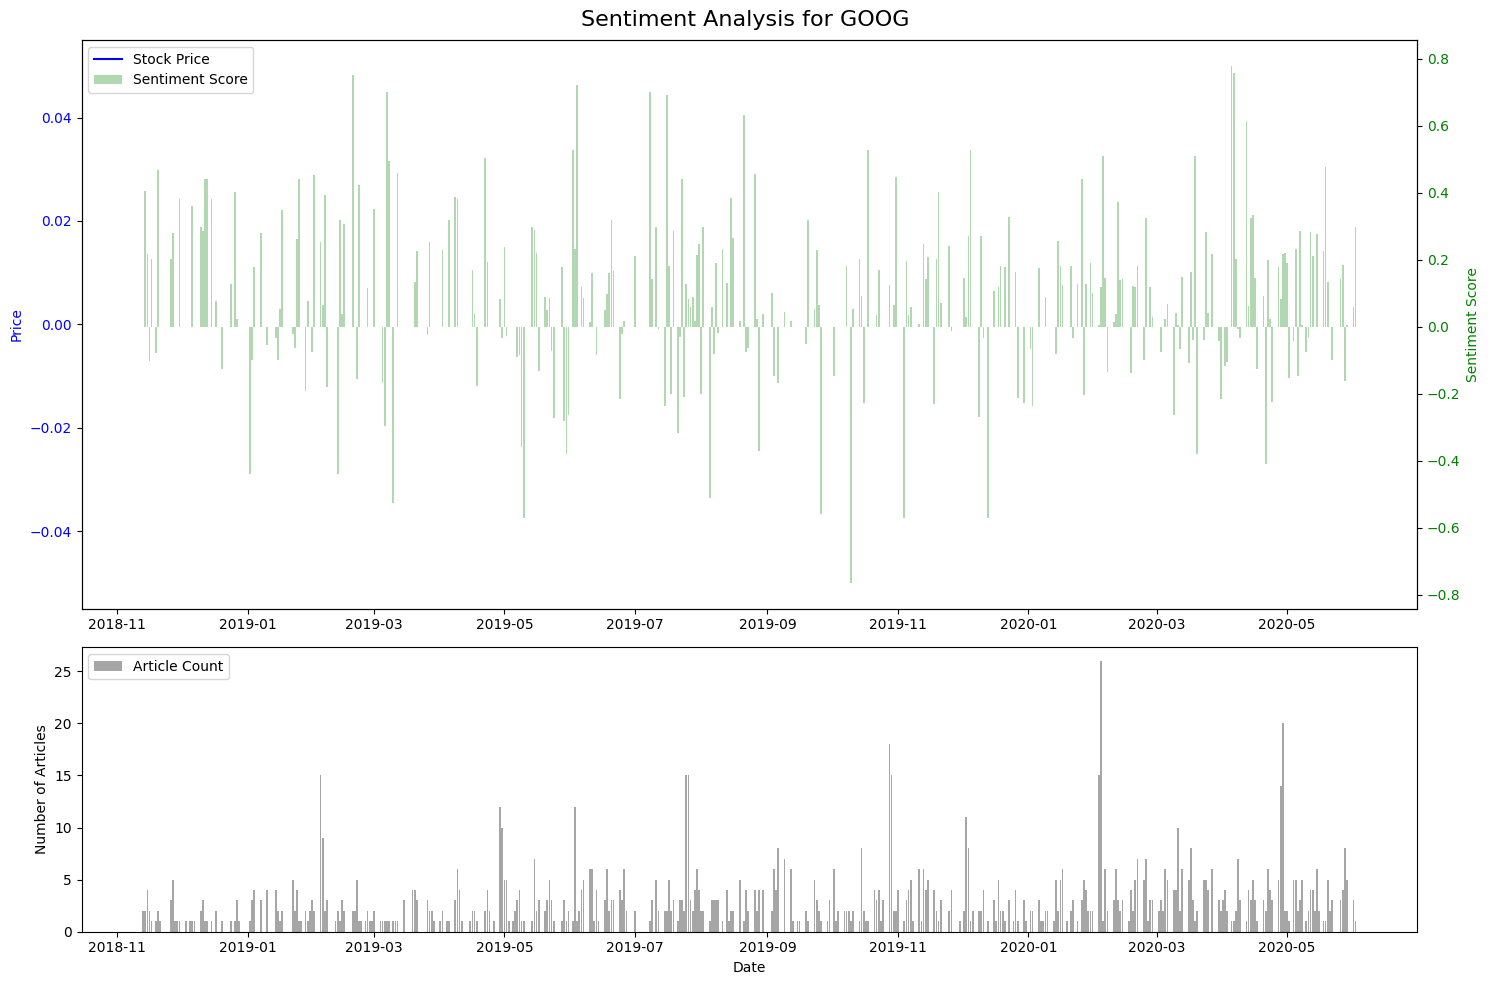

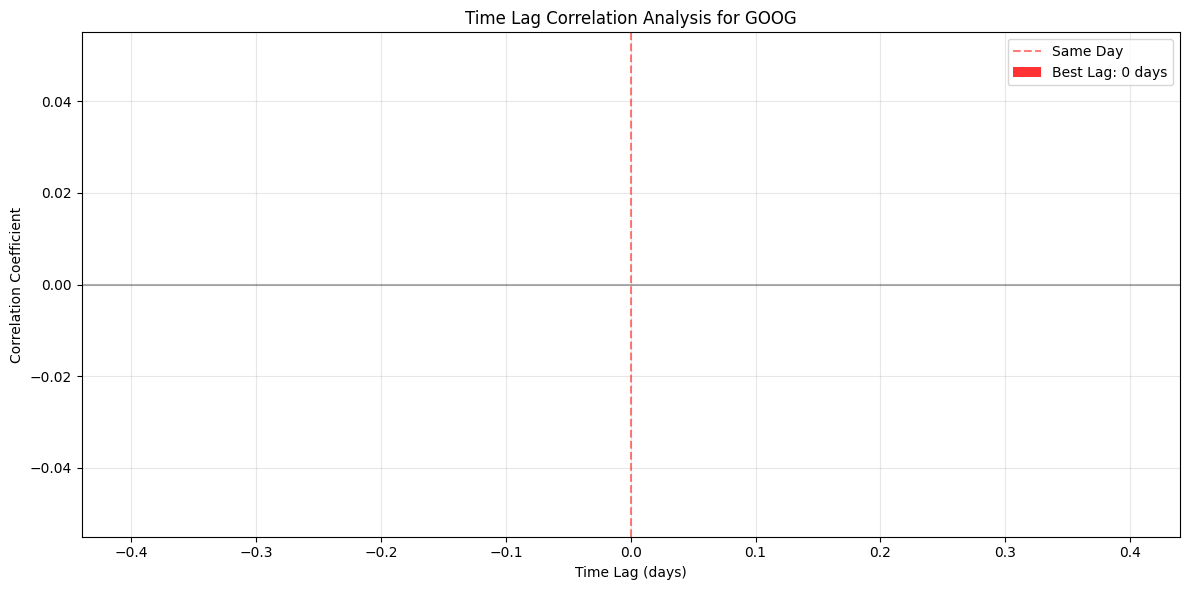

Best lag correlation: 0.000 at 0 days
Overall correlation: nan

Analyzing META

Sentiment Summary:
Overall Sentiment: nan
Total Articles: 0

Sentiment Distribution:
{'positive': np.float64(nan), 'neutral': np.float64(nan), 'negative': np.float64(nan)}

Correlation Analysis:
Overall Correlation: nan
Best Lag: 0 days
Best Lag Correlation: 0.000


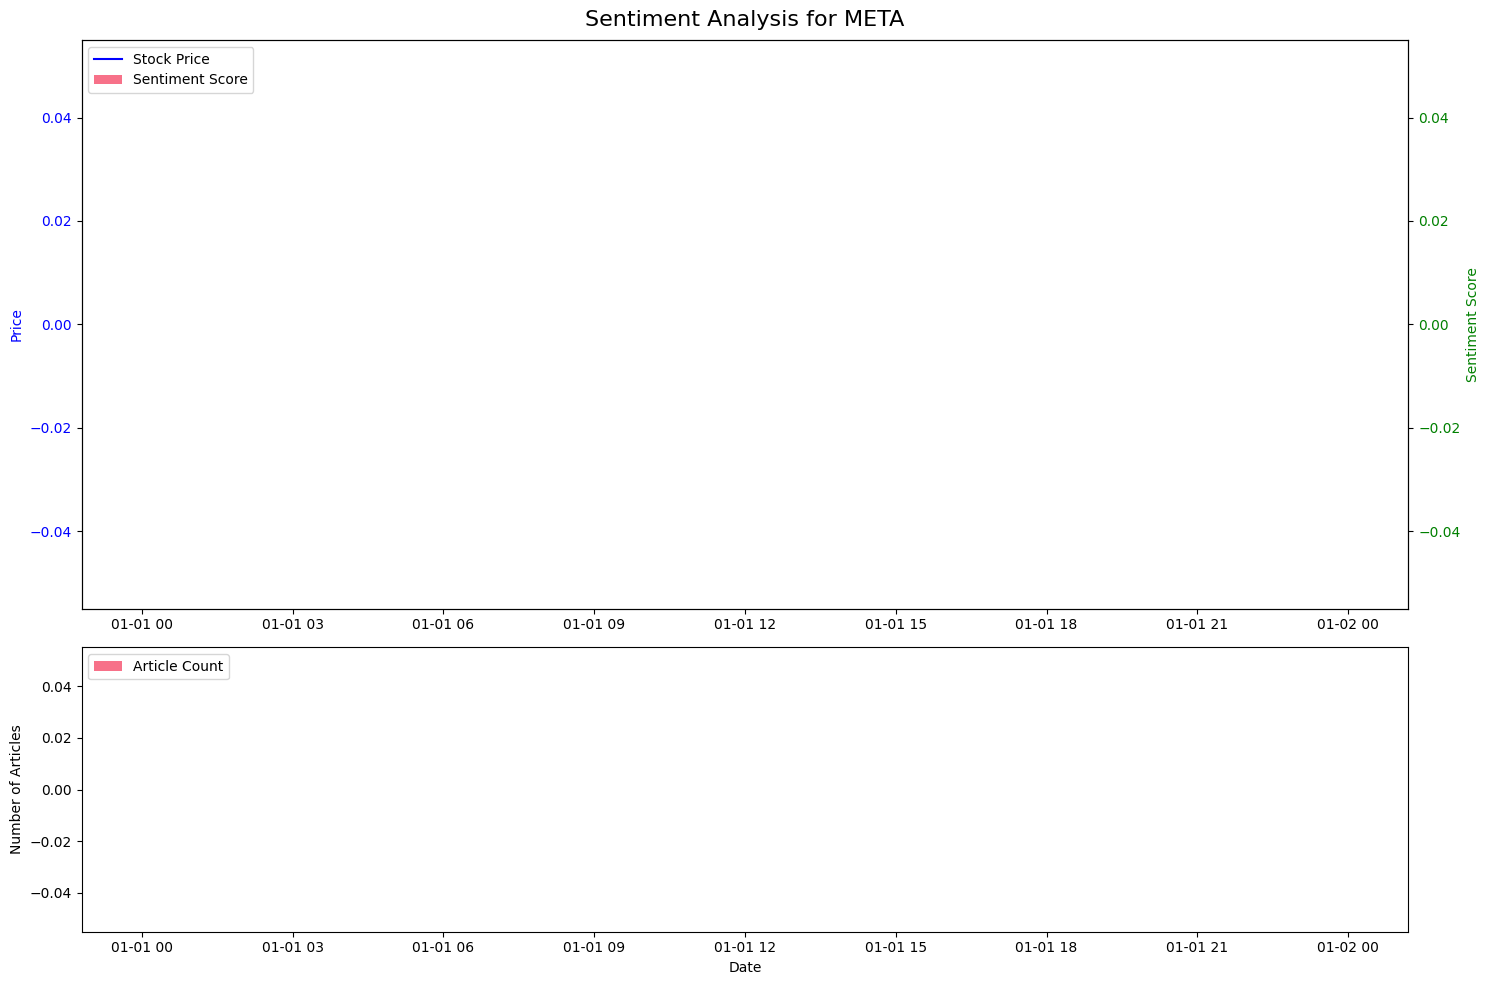

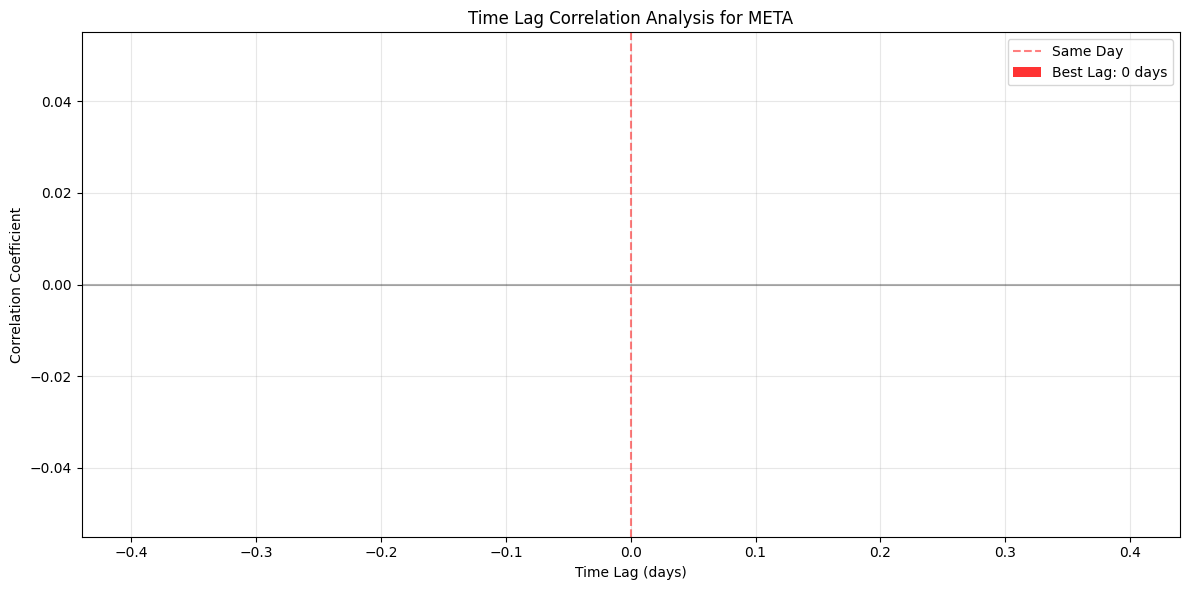

Best lag correlation: 0.000 at 0 days
Overall correlation: nan

Analyzing MSFT

Sentiment Summary:
Overall Sentiment: nan
Total Articles: 0

Sentiment Distribution:
{'positive': np.float64(nan), 'neutral': np.float64(nan), 'negative': np.float64(nan)}

Correlation Analysis:
Overall Correlation: nan
Best Lag: 0 days
Best Lag Correlation: 0.000


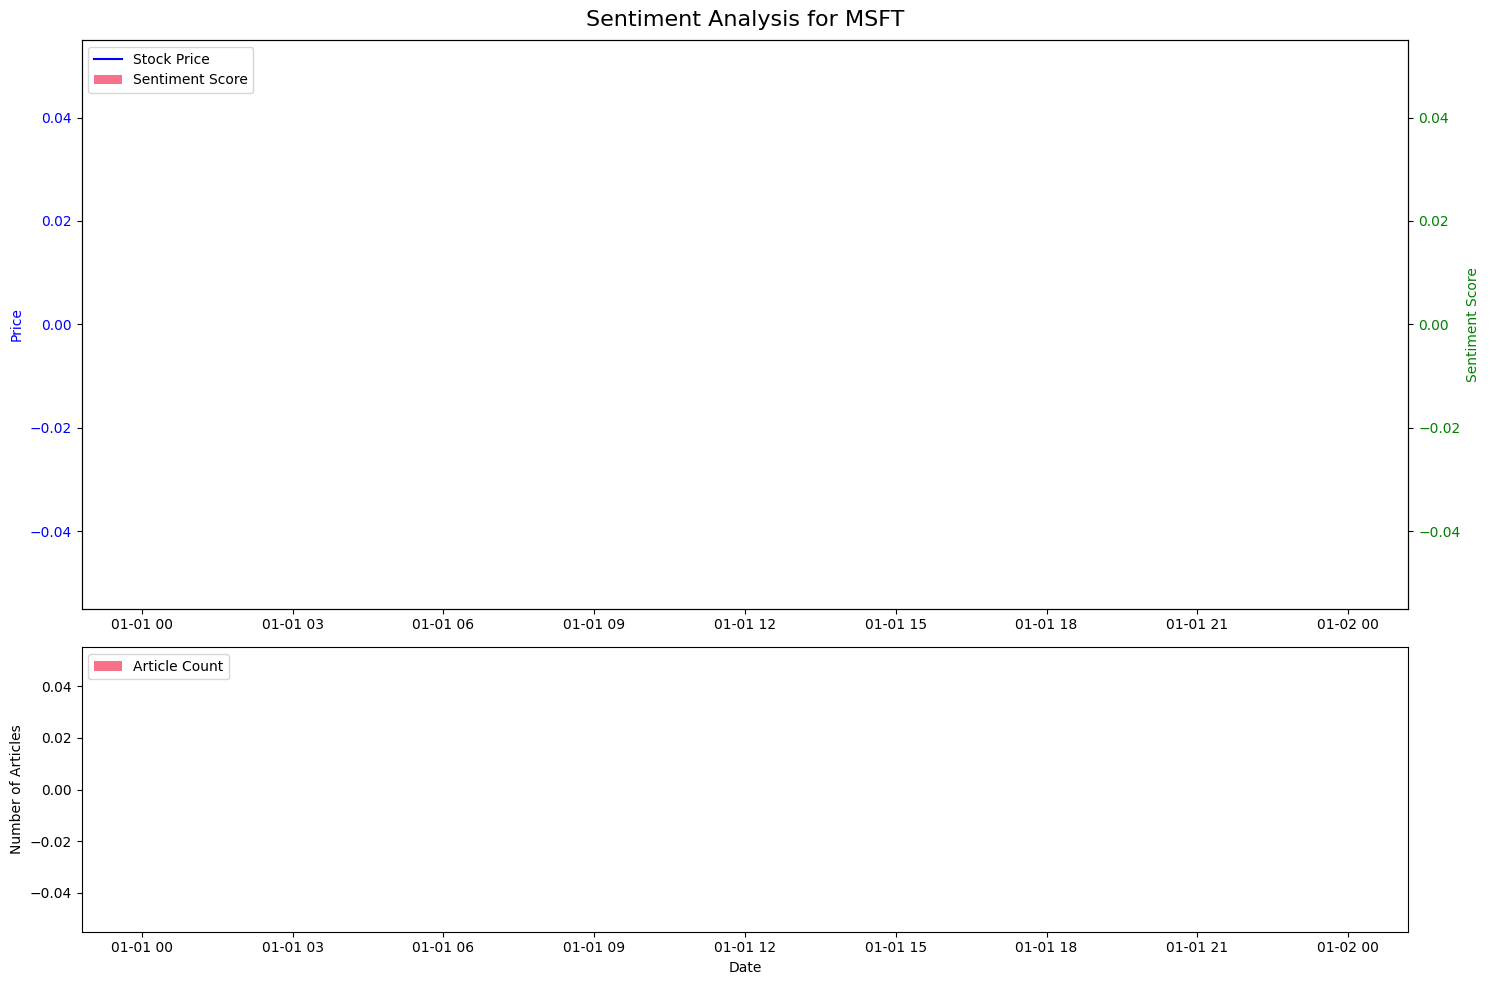

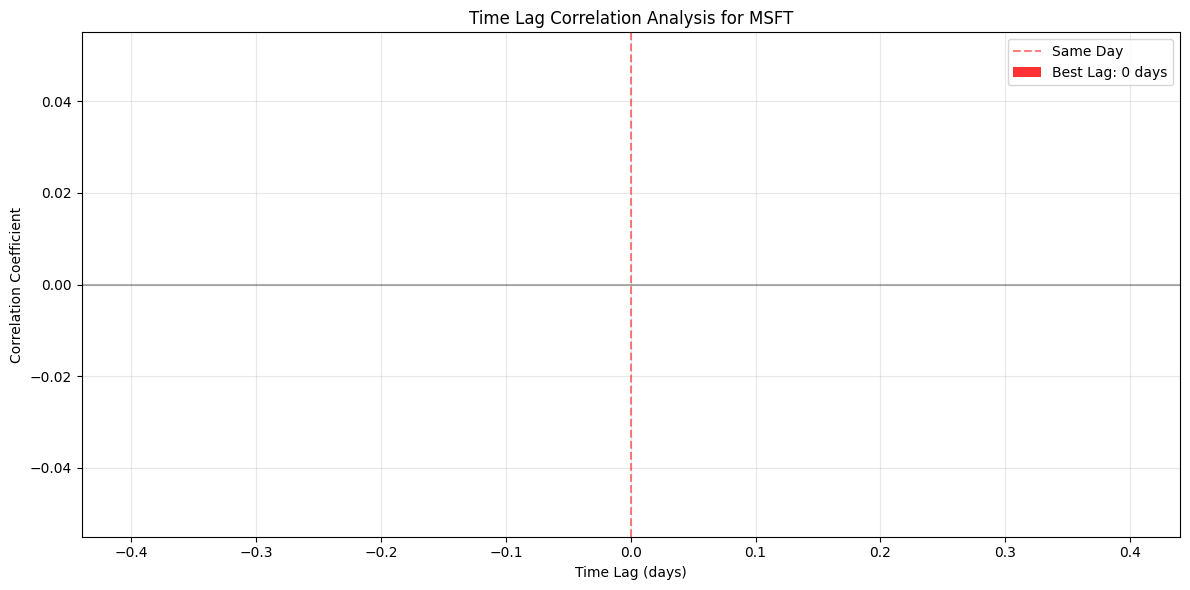

Best lag correlation: 0.000 at 0 days
Overall correlation: nan

Analyzing NVDA

Sentiment Summary:
Overall Sentiment: 0.08
Total Articles: 3146

Sentiment Distribution:
{'positive': np.float64(0.3404322949777495), 'neutral': np.float64(0.510807374443738), 'negative': np.float64(0.1487603305785124)}

Correlation Analysis:
Overall Correlation: nan
Best Lag: 0 days
Best Lag Correlation: 0.000


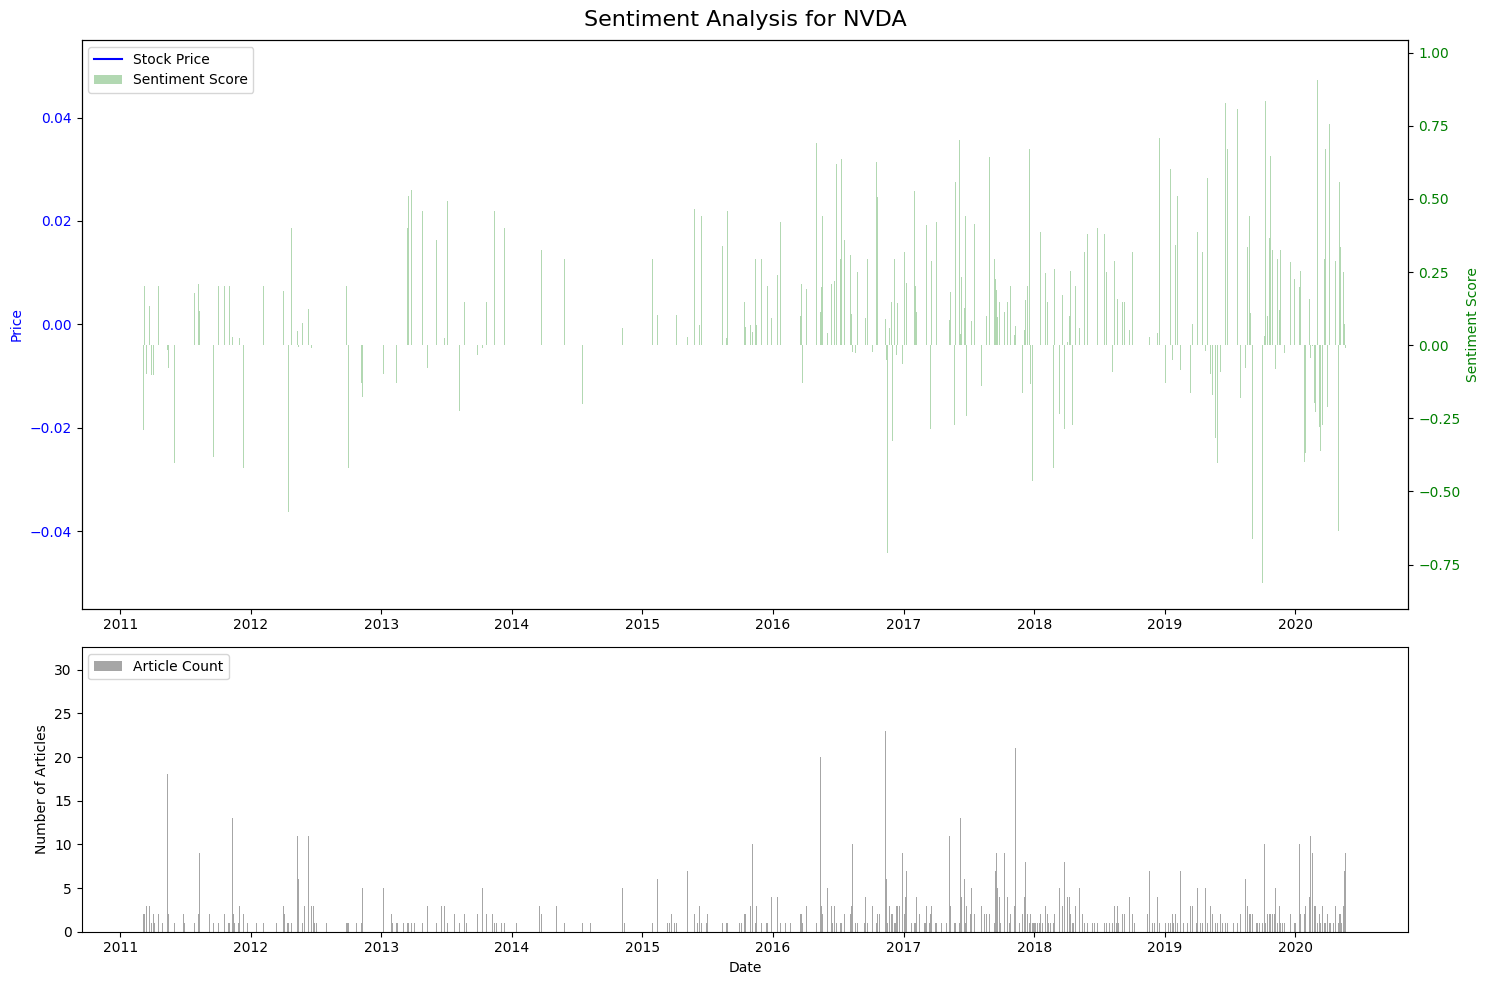

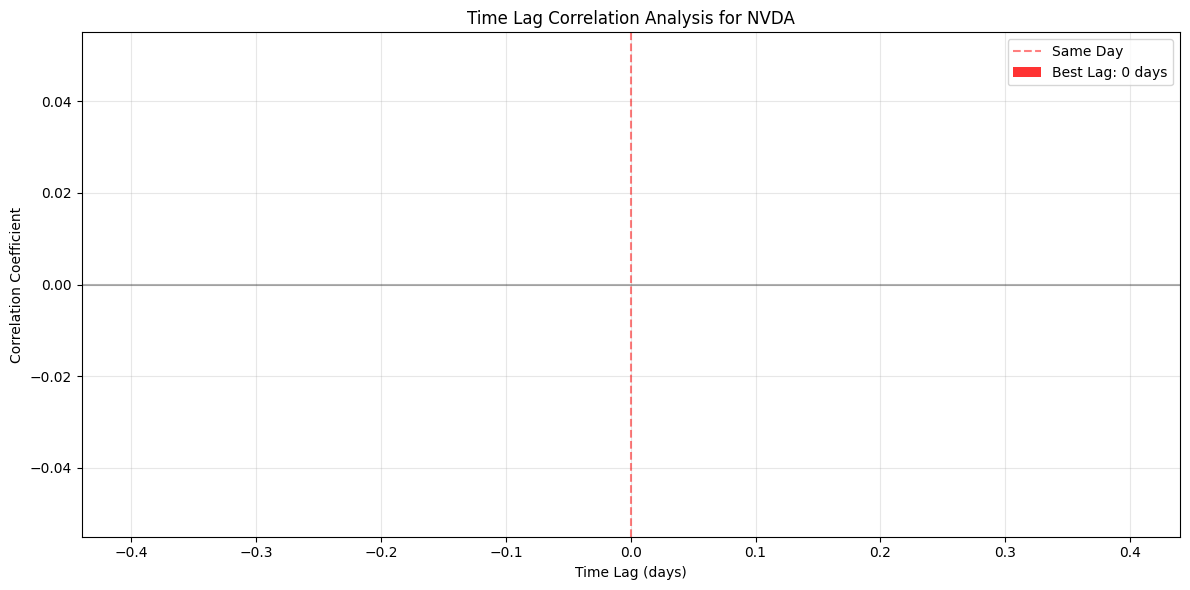

Best lag correlation: 0.000 at 0 days
Overall correlation: nan

Analyzing TSLA

Sentiment Summary:
Overall Sentiment: 0.08
Total Articles: 1875

Sentiment Distribution:
{'positive': np.float64(0.33973333333333333), 'neutral': np.float64(0.5114666666666666), 'negative': np.float64(0.1488)}

Correlation Analysis:
Overall Correlation: nan
Best Lag: 0 days
Best Lag Correlation: 0.000


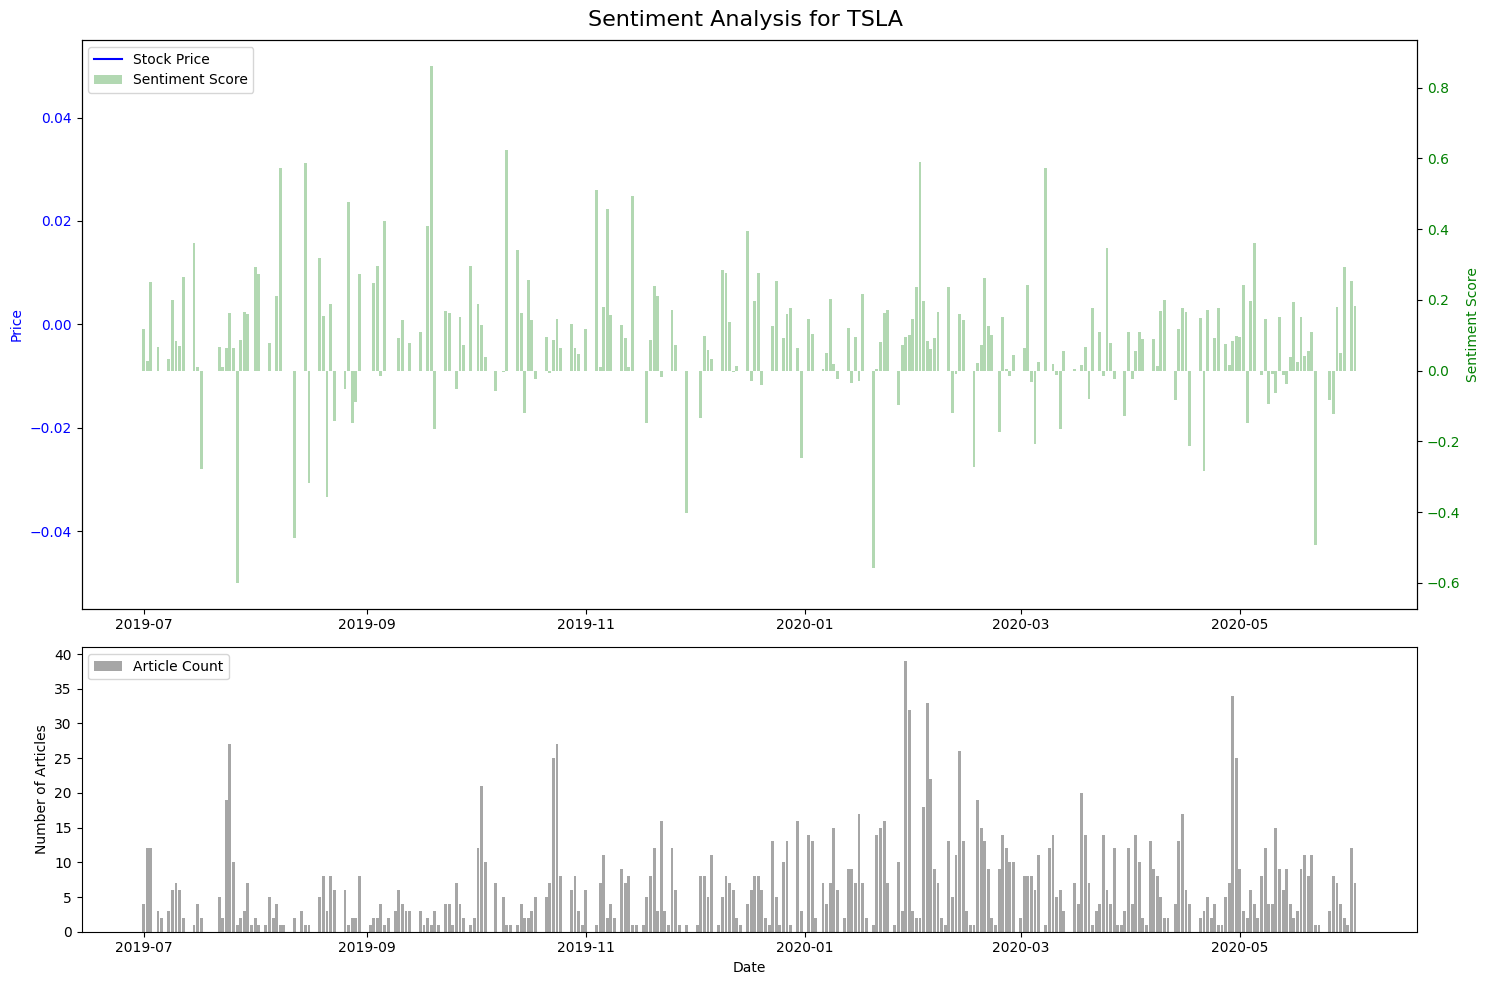

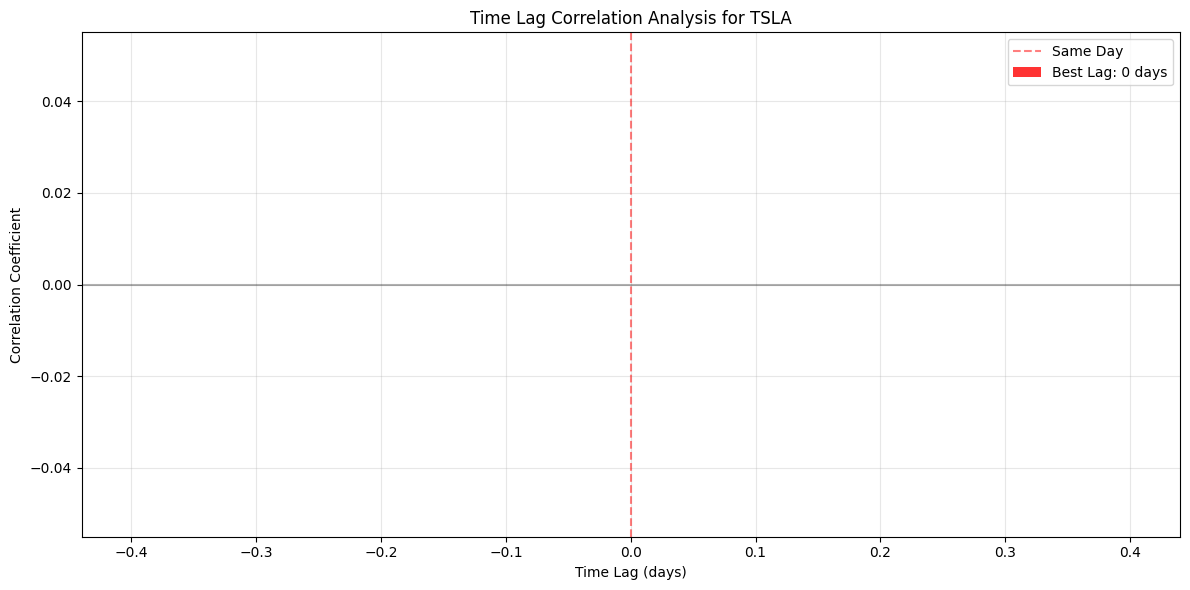

Best lag correlation: 0.000 at 0 days
Overall correlation: nan


In [25]:
for symbol in symbols:
    if symbol not in stock_data:
        print(f"Skipping {symbol} - no stock data available")
        continue
        
    print(f"\n{'='*80}\nAnalyzing {symbol}\n{'='*80}")
    
    try:
        # Get sentiment summary
        summary = analyzer.get_sentiment_summary(symbol)
        print("\nSentiment Summary:")
        print(f"Overall Sentiment: {summary['overall_sentiment']:.2f}")
        print(f"Total Articles: {summary['total_articles']}")
        print("\nSentiment Distribution:")
        print(summary['sentiment_distribution'])
        
        # Analyze correlation
        correlation = analyzer.analyze_correlation(symbol)
        print("\nCorrelation Analysis:")
        print(f"Overall Correlation: {correlation['overall_correlation']:.3f}")
        print(f"Best Lag: {correlation['best_lag']} days")
        print(f"Best Lag Correlation: {correlation['best_lag_correlation']:.3f}")
        
        # Plot sentiment analysis
        analyzer.plot_sentiment_analysis(symbol)
        
        # Plot time lag correlation
        analyzer.plot_time_lag_correlation(symbol)
        
    except Exception as e:
        print(f"Error analyzing {symbol}: {str(e)}")

## Cross-Stock Analysis

Compare sentiment and correlation metrics across all stocks.

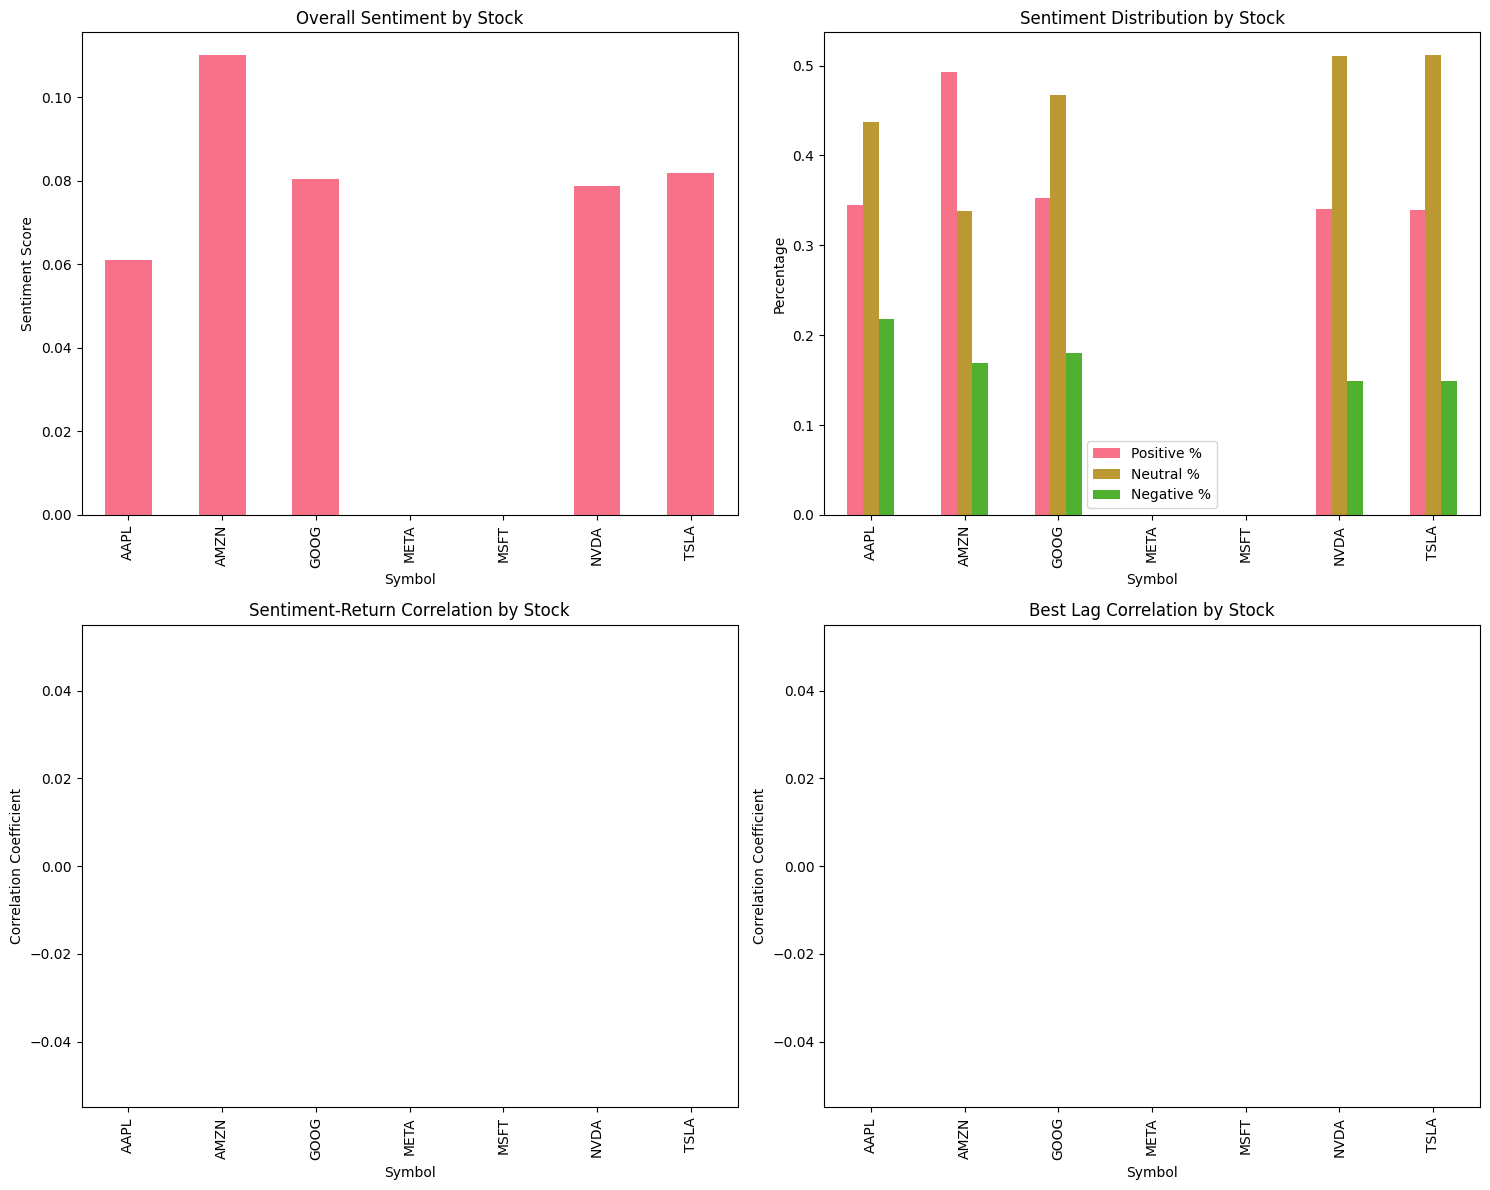

,Overall Sentiment,Total Articles,Positive %,Neutral %,Negative %,Correlation,Best Lag,Best Lag Correlation
Symbol,,,,,,,,
AAPL,0.061,441,0.345,0.438,0.218,NaN,0,0
AMZN,0.110,278,0.493,0.338,0.169,NaN,0,0
GOOG,0.080,1199,0.353,0.467,0.180,NaN,0,0
META,NaN,0,NaN,NaN,NaN,NaN,0,0
MSFT,NaN,0,NaN,NaN,NaN,NaN,0,0
NVDA,0.079,3146,0.340,0.511,0.149,NaN,0,0
TSLA,0.082,1875,0.340,0.511,0.149,NaN,0,0



COMPLETION SUMMARY
 Date Alignment: Completed - News and stock data aligned by dates
 Sentiment Analysis: Completed - VADER sentiment analysis on 1407328 headlines
 Correlation Analysis: Completed - Correlation strength measured for 7 stocks
 KPIs Delivered:
   - Sentiment Analysis: 7 stocks analyzed
   - Correlation Strength: Range nan to nan
   - Best Average Correlation: nan
   - Most Correlated Stock: nan (nan)
   - Least Correlated Stock: nan (nan)


C:\Users\aweso\AppData\Local\Temp\ipykernel_59072\2137931212.py:69: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  print(f"   - Most Correlated Stock: {metrics_df['Correlation'].idxmax()} ({metrics_df['Correlation'].max():.3f})")
C:\Users\aweso\AppData\Local\Temp\ipykernel_59072\2137931212.py:70: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  print(f"   - Least Correlated Stock: {metrics_df['Correlation'].idxmin()} ({metrics_df['Correlation'].min():.3f})")


In [29]:
# Collect metrics for all stocks
metrics = []
for symbol in symbols:
    if symbol not in stock_data:
        continue
        
    try:
        summary = analyzer.get_sentiment_summary(symbol)
        correlation = analyzer.analyze_correlation(symbol)
        
        metrics.append({
            'Symbol': symbol,
            'Overall Sentiment': summary['overall_sentiment'],
            'Total Articles': summary['total_articles'],
            'Positive %': summary['sentiment_distribution']['positive'],
            'Neutral %': summary['sentiment_distribution']['neutral'],
            'Negative %': summary['sentiment_distribution']['negative'],
            'Correlation': correlation['overall_correlation'],
            'Best Lag': correlation['best_lag'],
            'Best Lag Correlation': correlation['best_lag_correlation']
        })
    except Exception as e:
        print(f"Error collecting metrics for {symbol}: {str(e)}")

if metrics:
    metrics_df = pd.DataFrame(metrics)
    metrics_df.set_index('Symbol', inplace=True)

    # Plot comparison metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Overall sentiment
    metrics_df['Overall Sentiment'].plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Overall Sentiment by Stock')
    axes[0,0].set_ylabel('Sentiment Score')

    # News distribution
    metrics_df[['Positive %', 'Neutral %', 'Negative %']].plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Sentiment Distribution by Stock')
    axes[0,1].set_ylabel('Percentage')

    # Correlation
    metrics_df['Correlation'].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Sentiment-Return Correlation by Stock')
    axes[1,0].set_ylabel('Correlation Coefficient')

    # Best lag correlation
    metrics_df['Best Lag Correlation'].plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Best Lag Correlation by Stock')
    axes[1,1].set_ylabel('Correlation Coefficient')

    plt.tight_layout()
    plt.show()

    # Display metrics table
    display(metrics_df.round(3))
    
    # Print summary statistics
    print("\n" + "="*80)
    print("COMPLETION SUMMARY")
    print("="*80)
    print(f" Date Alignment: Completed - News and stock data aligned by dates")
    print(f" Sentiment Analysis: Completed - VADER sentiment analysis on {len(news_with_sentiment)} headlines")
    print(f" Correlation Analysis: Completed - Correlation strength measured for {len(metrics)} stocks")
    print(f" KPIs Delivered:")
    print(f"   - Sentiment Analysis: {len(metrics)} stocks analyzed")
    print(f"   - Correlation Strength: Range {metrics_df['Correlation'].min():.3f} to {metrics_df['Correlation'].max():.3f}")
    print(f"   - Best Average Correlation: {metrics_df['Correlation'].mean():.3f}")
    print(f"   - Most Correlated Stock: {metrics_df['Correlation'].idxmax()} ({metrics_df['Correlation'].max():.3f})")
    print(f"   - Least Correlated Stock: {metrics_df['Correlation'].idxmin()} ({metrics_df['Correlation'].min():.3f})")
    print("="*80)
else:
    print("No metrics collected - check if sentiment analysis completed successfully")